# <center> SABR calibration </center>

$$ df_t = \alpha_t f_t^ dW_t^1\beta $$ 
$$ d \alpha_t = v \alpha_t f_t^ dW_t^2$$ 
$$E[dW_t^1, dW_t^2] = \rho dt$$

$$\sigma_B = \frac{\alpha(1+[\frac{(1-\beta)^2}{24} \frac{\alpha^2}{(fK)^{1-\beta}} + \frac{\rho \beta v \alpha}{4(fK)^{(1-\beta)/2}}+\frac{2-3\rho^2}{24}v^2]T)}{(fK)^{(1-\beta)/2}[1+\frac{(1-\beta)^2}{24} \ln{(\frac{f}{K})}^2 + \frac{(1-\beta)^4}{1920} \ln{(\frac{f}{K})}^4]} * \frac{z}{\xi(z)}$$
$$z = \frac{v}{\alpha}(fK)^{(1-\beta)/2}\ln{(f/K)^2}$$
$$\xi(z) = \ln{[\frac{\sqrt{1-2z\rho+z^2}+z-\rho}{1-\rho}]}$$

Finding $\beta$:
$$\sigma_{ATM} = \sigma_{B} (f, f) =  \frac{\alpha(1+[\frac{(1-\beta)^2}{24} \frac{\alpha^2}{(f)^{2-2\beta}} + \frac{\rho \beta v \alpha}{4(f)^{(1-\beta)}}+\frac{2-3\rho^2}{24}v^2]T)}{f^{1 - \beta}} $$

$$\ln \sigma_{ATM} \approx \ln \alpha - (1 - \beta) \ln {f}$$

$$ \ln \alpha - (1 - \beta) \ln {f} \sim \sigma^{market} $$


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
from matplotlib.pyplot import figure
from importlib import reload
import numba as nb
import sys
import src.SABR.sabr_approx_div
reload(src.SABR.sabr_approx_div)
from src.SABR.sabr_approx_div import calibrate_sabr
from src.utils import process_data, round_params
import datetime
import warnings
warnings.filterwarnings("ignore")
import h5py
import matplotlib.dates as mdates
from tqdm.notebook import tqdm

In [2]:
%%time
raw = pd.HDFStore('datasets/eth-20230224.h5','r').get("/eth")
# raw2 = pd.HDFStore('../datasets/eth-20230127.h5','r').get("/eth")
# raw3 = pd.HDFStore('../datasets/eth-20230310.h5','r').get("/eth")
# raw = pd.concat([raw1, raw2, raw3]).drop_duplicates()
# raw.dt.hist(bins = 100)

CPU times: user 21.1 s, sys: 3.07 s, total: 24.2 s
Wall time: 25.6 s


In [3]:
%%time
# resample on 5 minutes
df = process_data(raw, 5)
df.head()

CPU times: user 20.9 s, sys: 2.78 s, total: 23.6 s
Wall time: 24.3 s


,instrument,dt,mark_price,type,strike_price,expiration,underlying_price,timestamp,tau,mark_price_usd
1,ETH-10FEB23-1000-P,2023-01-27 07:45:00,0.0010,put,1000,1675987200000000,1581.733579,1674805500000000,0.037471,1.581734
3,ETH-10FEB23-1100-P,2023-01-27 07:45:00,0.0015,put,1100,1675987200000000,1581.733579,1674805500000000,0.037471,2.372600
5,ETH-10FEB23-1150-P,2023-01-27 07:45:00,0.0020,put,1150,1675987200000000,1581.733579,1674805500000000,0.037471,3.163467
7,ETH-10FEB23-1200-P,2023-01-27 07:45:00,0.0025,put,1200,1675987200000000,1581.733579,1674805500000000,0.037471,3.954334
9,ETH-10FEB23-1250-P,2023-01-27 07:45:00,0.0035,put,1250,1675987200000000,1581.733579,1674805500000000,0.037471,5.536068


# Params dynamics

In [4]:
%%time
df_for_pnl = pd.DataFrame(columns = ['type', 'strike_price', 'expiration', 'underlying_price', 'iv',
       'calibrated_iv', 'calibrated_mark_price', 'delta', 
                        'vega', 'gamma' ,'sega', 'rega', 'mark_price_usd', 'rho', 'volvol', 'timestamp'])

timestamps_hm = []

params_all = []
params_beta = []

errors_all = []
errors_beta = []

alpha = np.float64(0.7)
v = np.float64(1.3)
beta = np.float64(0.9)  
rho = np.float64(-0.1) 

start_params = np.array([alpha, v, beta, rho])

# Get ticks with similar distnce from available data
calibr_borders = df[(df["dt"] >= "2023-02-04") & (df["dt"] <= "2023-02-04 23:00:00")].copy()
df_only_exp = calibr_borders[calibr_borders["expiration"] == calibr_borders.sample(1).expiration.iloc[0]].copy()

print("Optimize first params with random start once")
calibrated_params_all, first_error_all, _ = calibrate_sabr(df = calibr_borders, 
                                                        start_params = start_params, 
                                                        calibration_type = "all")
calibrated_params_beta, first_error_beta, _ = calibrate_sabr(df = calibr_borders, 
                                                        start_params = start_params, 
                                                        calibration_type = "beta", beta = 1.0)


print("All first calibrated:", round_params(calibrated_params_all), "error:", first_error_all)
print("Beta first calibrated:", round_params(calibrated_params_beta), "error:", first_error_beta)


# timestamps = np.linspace(calibr_borders.timestamp.min(), calibr_borders.timestamp.max(), number_of_dots)
timestamps = calibr_borders["dt"].unique()
for timestamp in tqdm(timestamps):
    try:
        # zero params for each point are params from last step
        calibrated_params_all, error_all, _ = calibrate_sabr(df = df_only_exp, start_params = calibrated_params_all, 
                                    timestamp = timestamp, calibration_type = "all")
        # we want to count unexpected pnl on beta fixed calibration variant
        calibrated_params_beta, error_beta, for_pnl = calibrate_sabr(df = df_only_exp, start_params = calibrated_params_beta, 
                                    timestamp = timestamp, calibration_type = "beta", beta = 1.0)
        for_pnl["timestamp"] = timestamp

        params_all.append(calibrated_params_all)
        errors_all.append(error_all)
        params_beta.append(calibrated_params_beta)
        errors_beta.append(error_beta)
        timestamps_hm.append(timestamp)
        df_for_pnl = df_for_pnl.append(for_pnl)
        
    except:
        calibrated_params_all = start_params
        print("Error!")

params_all = np.array(params_all).T
params_beta = np.array(params_beta).T





Optimize first params with random start once
All first calibrated: [8.498, 5.281, 0.644, -0.018] error: 0.015853162763338733
Beta first calibrated: [0.615, 4.997, 1.0, -0.127] error: 0.01357706081139501


  0%|          | 0/277 [00:00<?, ?it/s]

CPU times: user 24 s, sys: 511 ms, total: 24.5 s
Wall time: 24.4 s


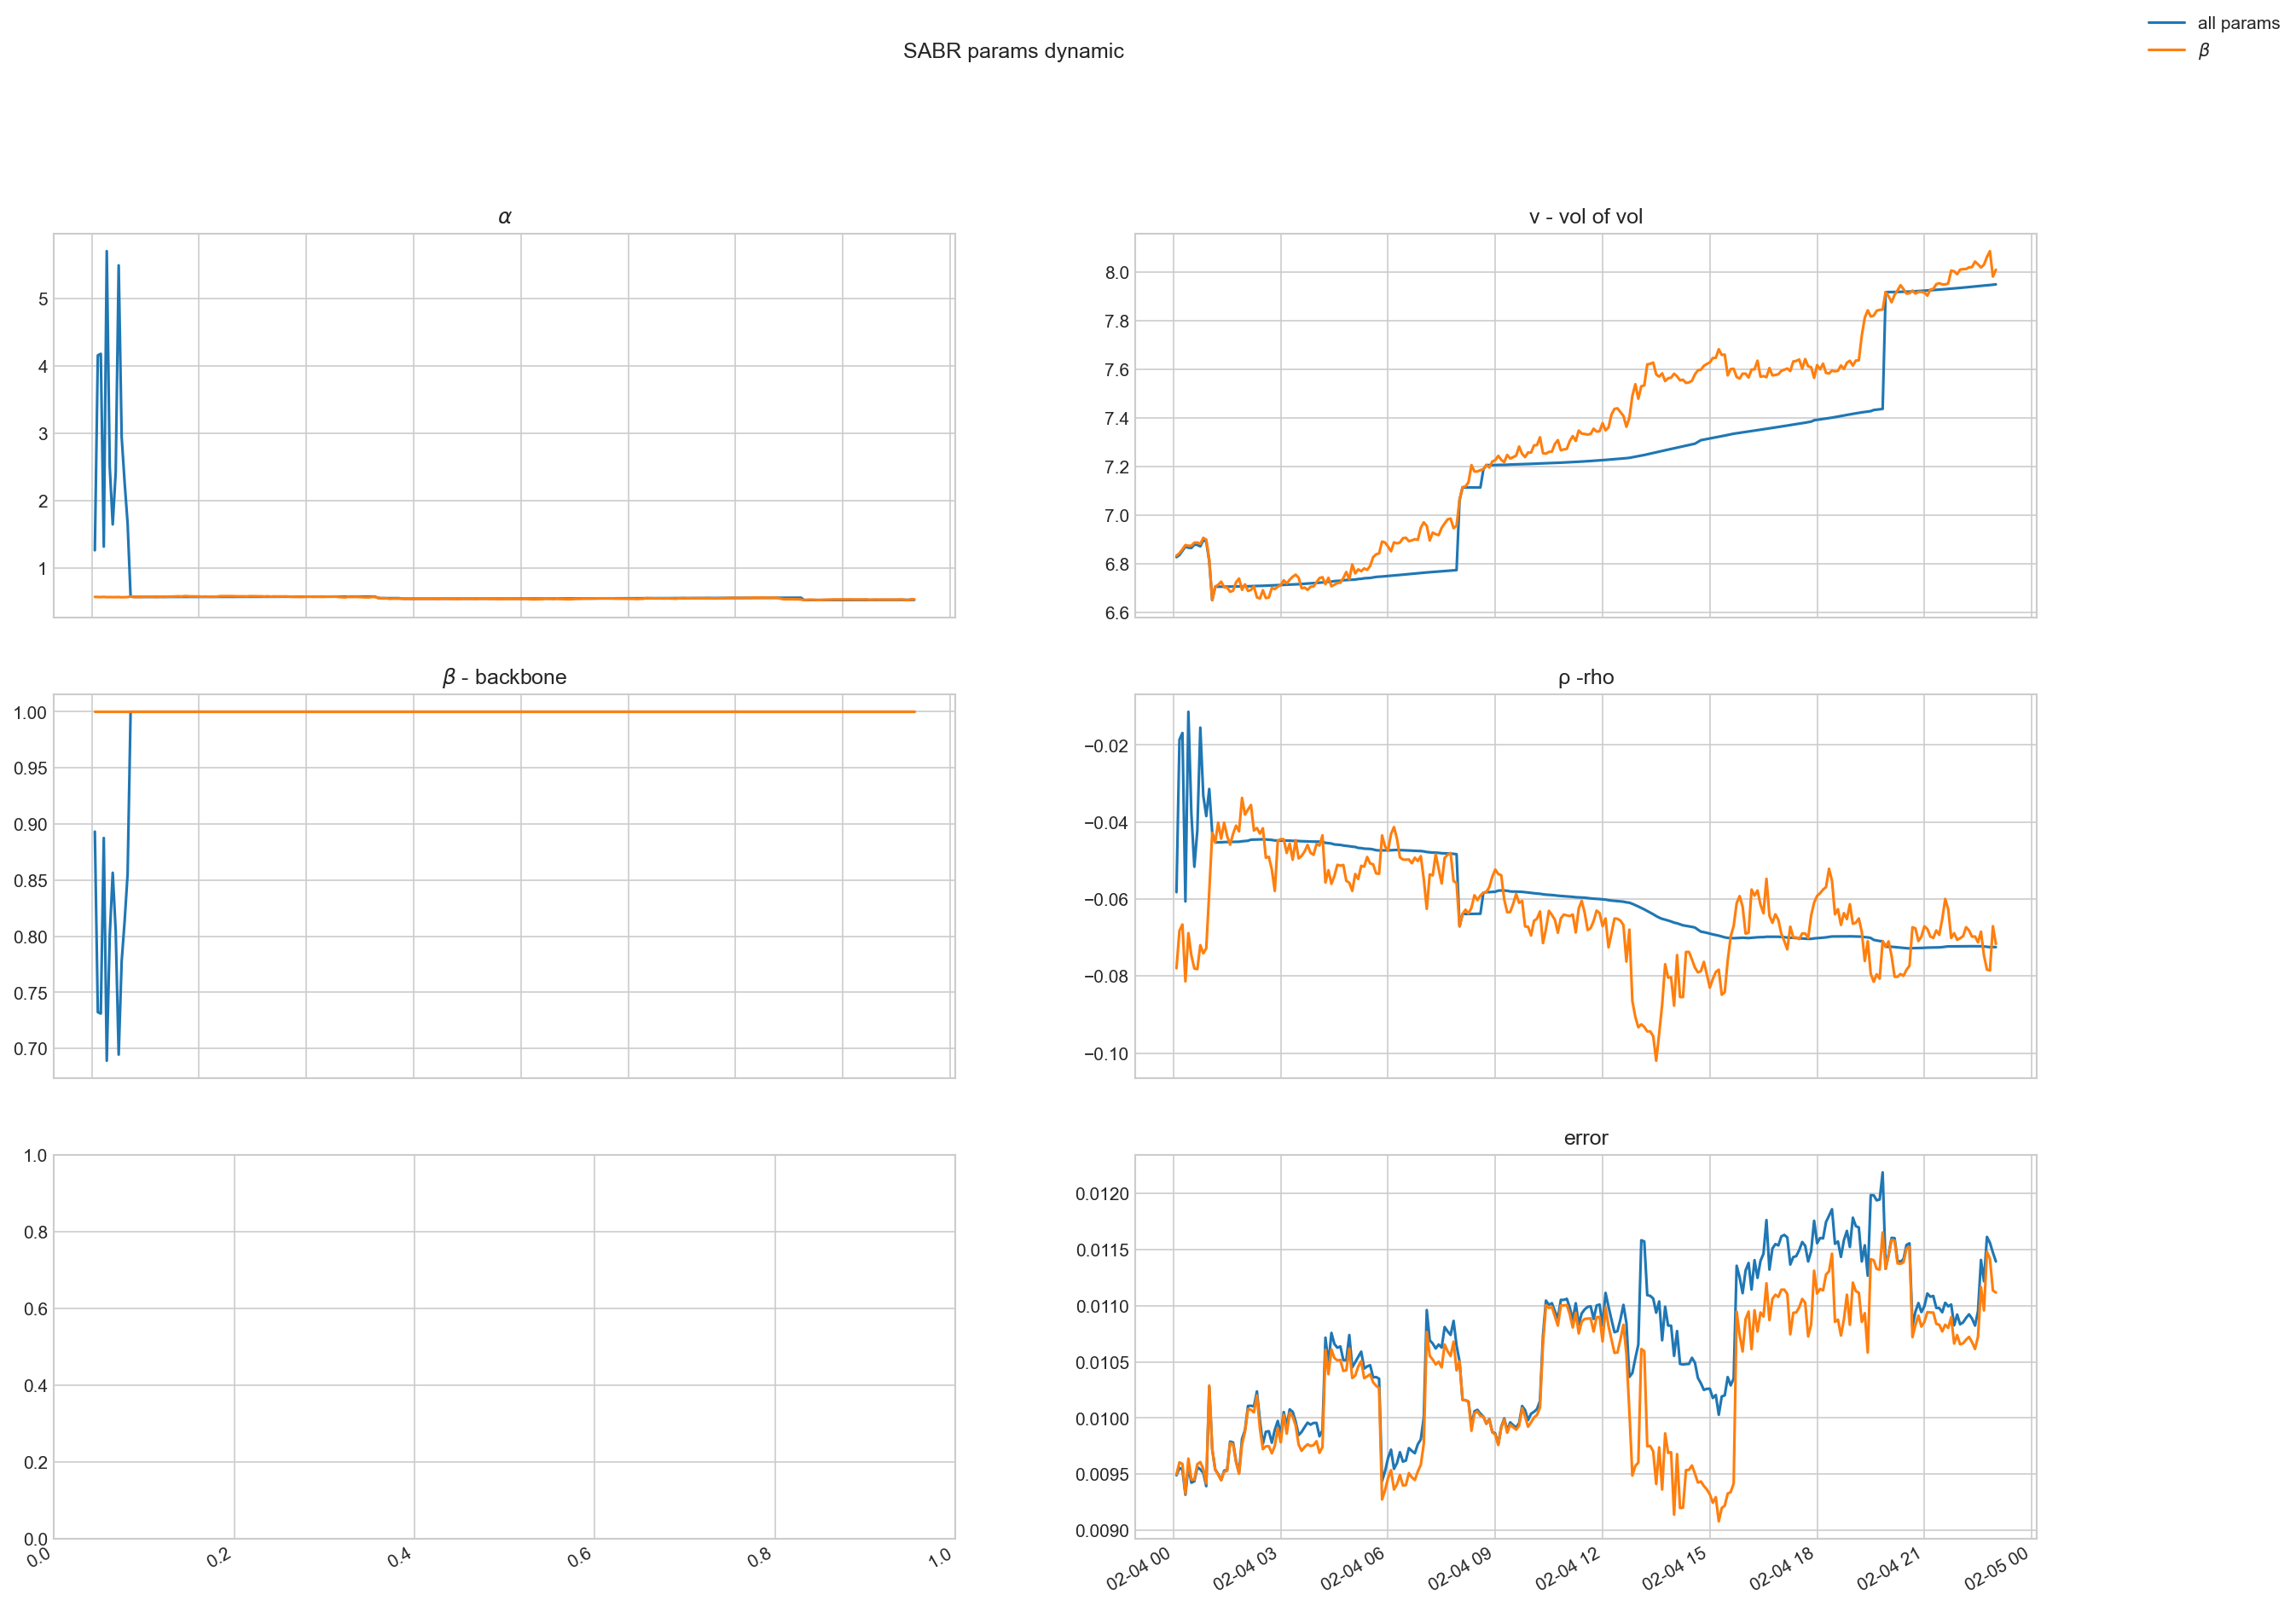

In [5]:
fig, axs =  plt.subplots(nrows=3, ncols=2, figsize=(20, 15), dpi = 150)

axs[0, 0].plot(timestamps_hm[1:], params_all[0][1:], label = "all params")
axs[0, 1].plot(timestamps_hm[1:], params_all[1][1:])
axs[1, 0].plot(timestamps_hm[1:], params_all[2][1:])
axs[1, 1].plot(timestamps_hm[1:], params_all[3][1:])
axs[2, 1].plot(timestamps_hm[1:], errors_all[1:])

axs[0, 0].plot(timestamps_hm[1:], params_beta[0][1:], label = r"$\beta$")
axs[0, 1].plot(timestamps_hm[1:], params_beta[1][1:])
axs[1, 0].plot(timestamps_hm[1:], params_beta[2][1:])
axs[1, 1].plot(timestamps_hm[1:], params_beta[3][1:])
axs[2, 1].plot(timestamps_hm[1:], errors_beta[1:])


axs[0, 0].set_title(r"$\alpha$")
axs[0, 1].set_title(r"v - vol of vol")
axs[1, 0].set_title(r"$\beta$ - backbone")
axs[1, 1].set_title("ρ -rho")
axs[2, 1].set_title("error")

plt.figlegend() 
fig.suptitle("SABR params dynamic")
plt.gcf().autofmt_xdate()
plt.show()

# Unexplained PNL

In [6]:
def get_pnl(df: pd.DataFrame, strike:int,  option_type: str = "call"):
    data = df[(df["strike_price"] == strike) & (df["type"] == option_type)].copy()
    assert len(data)!=0, "Choose from available out of the money strikes"
#     data["mark_price_usd"] = data["mark_price"]*data["underlying_price"]
    data["calibrated_iv"] = data["calibrated_iv"]/100
    data["underlying_price_shift"] = data["underlying_price"].shift(-1)
    data["mark_price_usd_shift"] = data["mark_price_usd"].shift(-1)
    data["calibrated_iv_shift"] = data["calibrated_iv"].shift(-1)
    data["rho_shift"] = data["rho"].shift(-1)
    data["volvol_shift"] = data["volvol"].shift(-1)
    data["expected_pnl"] = (data["mark_price_usd"] - 
                            data["delta"]*(data["underlying_price_shift"] - data["underlying_price"]) -
                            data["vega"]*(data["calibrated_iv_shift"] - data["calibrated_iv"]) - 
                            data["sega"]*(data["rho_shift"] - data["rho"]) - 
                            data["rega"]*(data["volvol_shift"] - data["volvol"]) -
                            1/2*data["gamma"]*(data["underlying_price_shift"] - data["underlying_price"])**2
                           )
    return data


Text(0.5, 0, 'date')

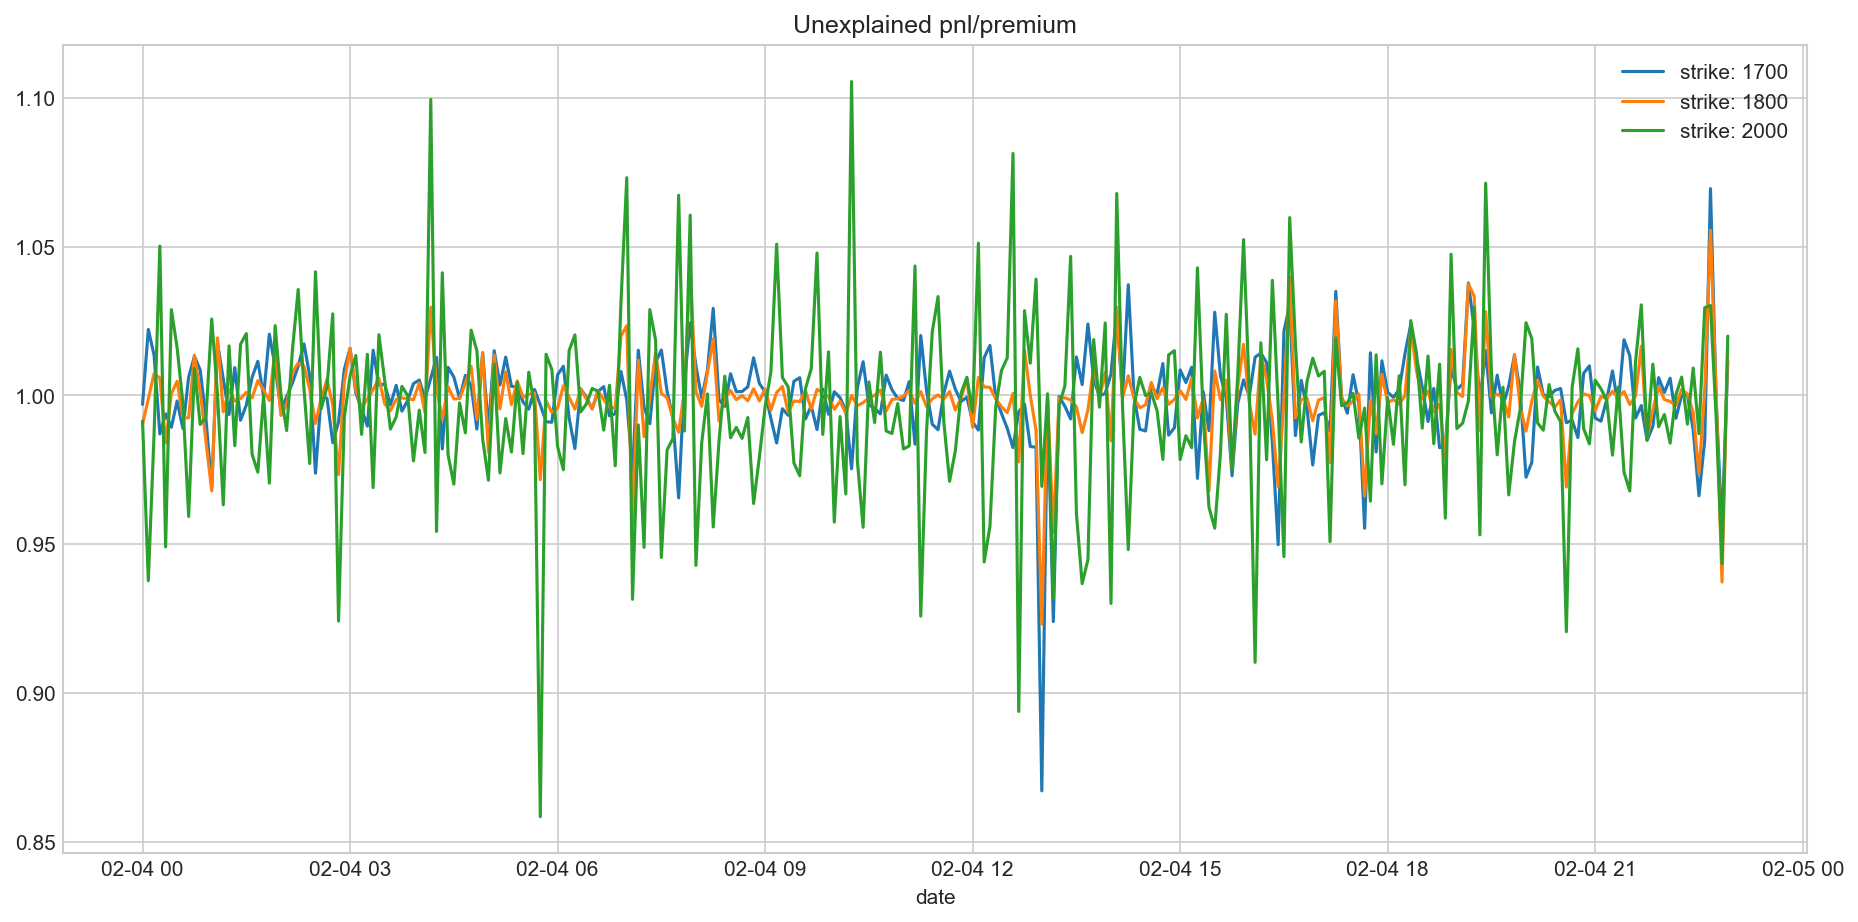

In [7]:
figure(figsize=(15, 7), dpi=150)
plt.title(f"Unexplained pnl/premium")

strikes_to_plot = [1700, 1800, 2000]
for strike in strikes_to_plot:
    data = get_pnl(df_for_pnl, strike)
    plt.plot(data["timestamp"], data["expected_pnl"]/data["mark_price_usd"], label = f"strike: {strike}")
plt.legend()
plt.xlabel("date")

# Volatility smile

All:
[0.519, 4.976, 1.0, -0.155]
0.007574471210383546
   
Beta:
[1.077, 4.962, 0.9, -0.13]
0.007599343825645905


Text(0.5, 0, 'Strike, USD')

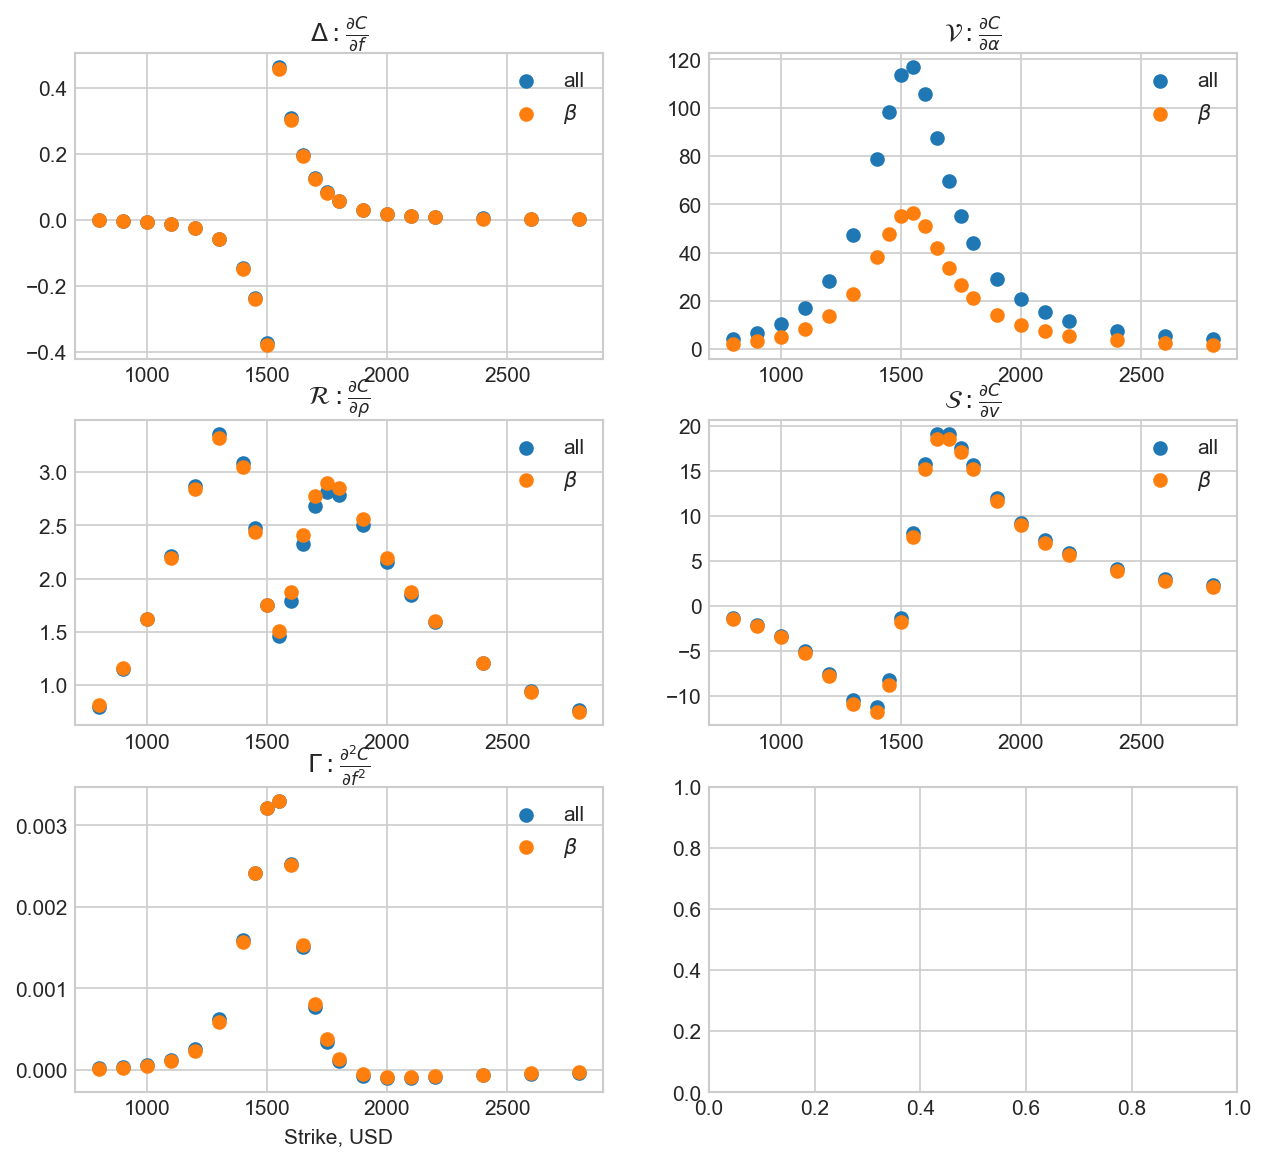

In [8]:
df_only_exp = df[df["expiration"] == df.sample(1).expiration.iloc[0]].copy()
needed_stamp = df_only_exp.sample(1).iloc[0]["dt"]

alpha = np.float64(1.3) 
v = np.float64(0.7) 
beta = np.float64(0.9) 
rho = np.float64(-0.1) 
start_params = np.array([alpha, v, beta, rho])

pars_all, err_all, C_all = calibrate_sabr(df = df_only_exp, 
                                          start_params = start_params, 
                                          timestamp = needed_stamp,
                                          calibration_type= "all")

pars_beta, err_beta, C_beta = calibrate_sabr(df = df_only_exp, 
                                          start_params = start_params, 
                                          timestamp = needed_stamp,
                                          calibration_type= "beta", beta = 0.9)

print("All:")
print(round_params(pars_all))
print(err_all)
print("   ")

print("Beta:")
print(round_params(pars_beta))
print(err_beta)


fig, axs =  plt.subplots(nrows=3, ncols=2, figsize=(10, 9), dpi = 150)
axs[0, 0].scatter(C_all["strike_price"], C_all["delta"], label = "all")
axs[0, 0].scatter(C_beta["strike_price"], C_beta["delta"], label = r"$\beta$")
axs[0, 0].set_title(r"$\Delta: \frac{\partial C}{\partial f}$")
axs[0, 0].legend()
# axs[0, 0]
# axs[0, 0].set_xlabel("Strike, USD")



axs[0, 1].scatter(C_all["strike_price"], C_all["vega"], label = "all")
axs[0, 1].scatter(C_beta["strike_price"], C_beta["vega"], label = r"$\beta$")
axs[0, 1].set_title(r"$\mathcal{V}: \frac{\partial C}{\partial \alpha}$")
axs[0, 1].legend()

# axs[0, 1].set_xlabel("Strike, USD")


axs[1, 0].scatter(C_all["strike_price"], C_all["rega"], label = "all")
axs[1, 0].scatter(C_beta["strike_price"], C_beta["rega"], label = r"$\beta$")
axs[1, 0].set_title(r"$\mathcal{R}: \frac{\partial C}{\partial \rho}$")
axs[1, 0].legend()
# axs[1, 0].set_xlabel("Strike, USD")

axs[1, 1].scatter(C_all["strike_price"], C_all["sega"], label = "all")
axs[1, 1].scatter(C_beta["strike_price"], C_beta["sega"], label = r"$\beta$")
axs[1, 1].set_title(r"$\mathcal{S}:\frac{\partial C}{\partial v}$")
axs[1, 1].legend()


axs[2, 0].scatter(C_all["strike_price"], C_all["gamma"], label = "all")
axs[2, 0].scatter(C_beta["strike_price"], C_beta["gamma"], label = r"$\beta$")
axs[2, 0].set_title(r"$\Gamma: \frac{\partial^2 C}{\partial f^2}$")
axs[2, 0].legend()
axs[2, 0].set_xlabel("Strike, USD")

# axs[2, 1].scatter(C_all["strike_price"], C_all["dc_dK"], label = "all")
# axs[2, 1].scatter(C_beta["strike_price"], C_beta["dc_dK"], label = r"$\beta$")
# axs[2, 1].set_title(r"$\mathcal{K}: \frac{\partial C}{\partial K}$")
# axs[2, 1].legend()
# axs[2, 1].set_xlabel("Strike, USD")
# axs[2, 1].set_xlabel("Strike, USD")


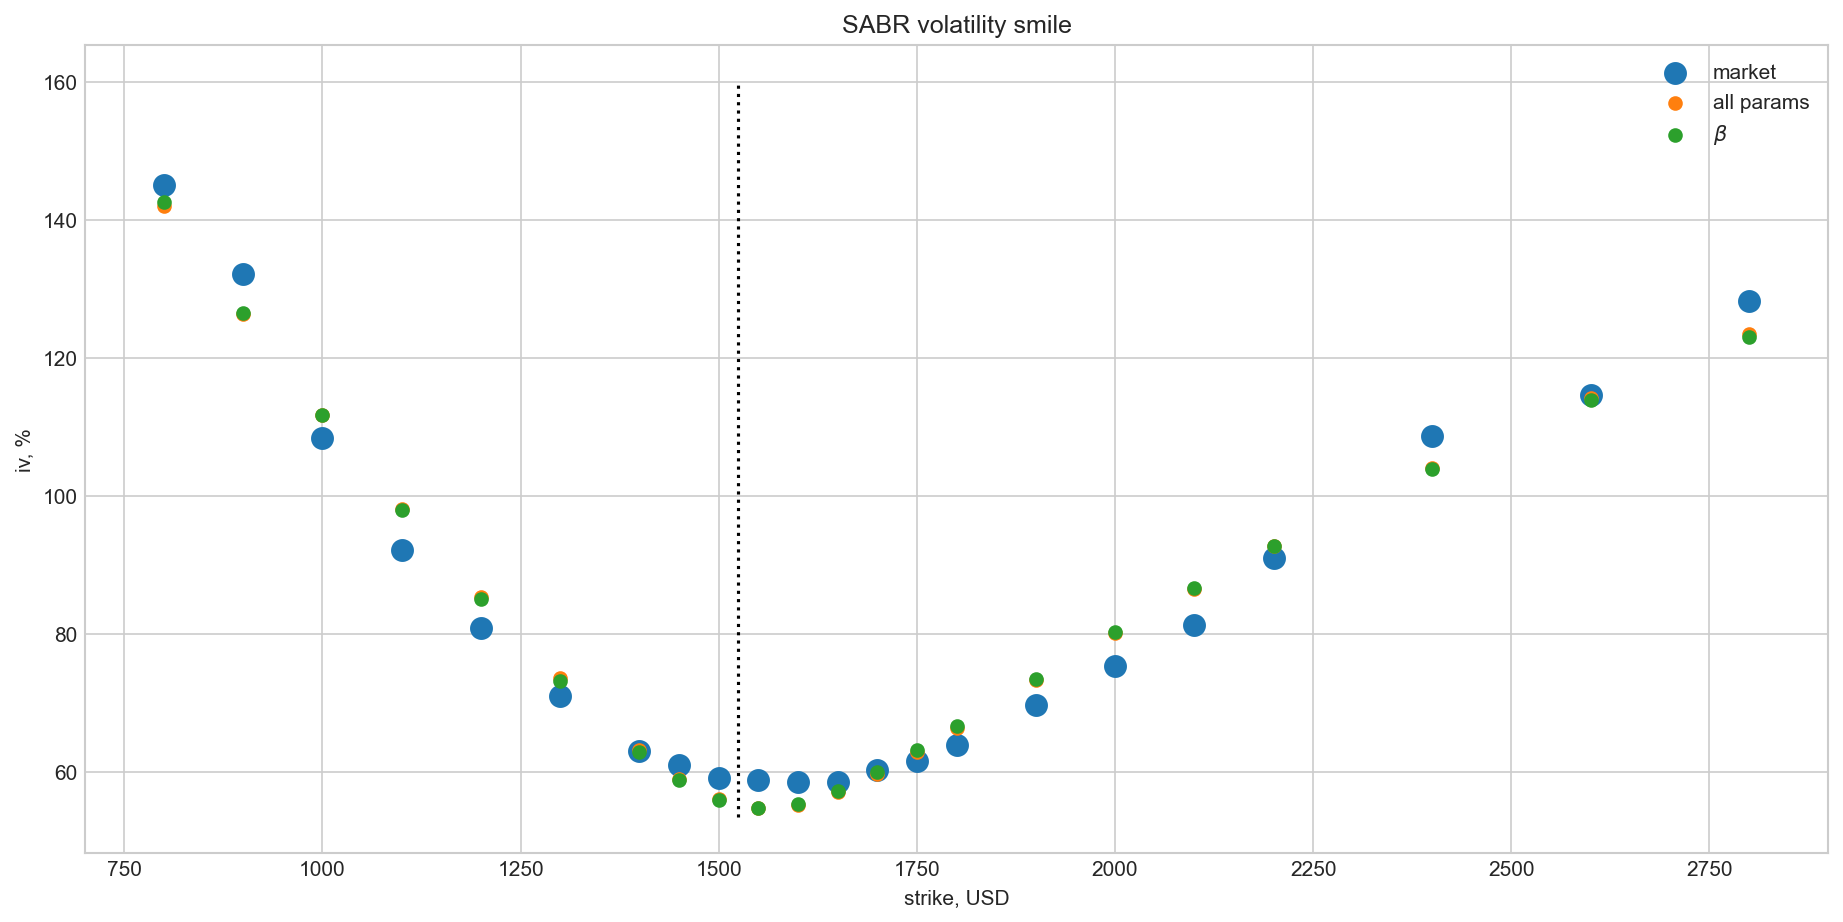

In [9]:
figure(figsize=(15, 7), dpi=150)

plt.scatter(C_all["strike_price"], C_all["iv"], label = "market", linewidths = 5)

# bid,ask iv
# plt.plot(C_sing_exp_all["strike_price"], C_sing_exp_all["ask_iv"], '--', label = "ask_iv", color = "black")
# plt.plot(C_sing_exp_all["strike_price"], C_sing_exp_all["bid_iv"], '--', label = "bid_iv", color = "yellow")

plt.scatter(C_all["strike_price"], C_all["calibrated_iv"], label = "all params")
plt.scatter(C_beta["strike_price"], C_beta["calibrated_iv"], label = r"$\beta$")


plt.vlines([C_all.underlying_price.mean()], C_all.iv.min() - 5, 
           C_all.iv.max() + 15, color = "black", linestyles = "dotted")

plt.title("SABR volatility smile")
plt.xlabel("strike, USD")
plt.ylabel("iv, %")
plt.legend()
plt.show()

# strike for given delta

$$g(K) = \Delta_{BSM} - \delta$$

$$g'(K) = N'(d_1) \frac{\partial d_1}{\partial K} = N'(d_1) \frac{\partial }{\partial K} \left( \frac{  \ln \frac{S}{K} + (r + \frac{\sigma^2(K)}{2})T}{\sigma(K) \sqrt T}  \right)  = $$

$$ = \frac{N'(d_1)}{\sqrt T} \frac{\partial }{\partial K} \left( \frac{\ln \frac{S}{K}}{\sigma(K)} + \frac{rT}{\sigma(K)} + \frac{\sigma(K)T}{2} \right) = $$

$$ = \frac{N'(d_1)}{\sqrt T} \left( -\frac{1}{K\sigma(K)} - \frac{\sigma'(K) \ln \frac{S}{K}}{\sigma^2(K)} - \frac{rT\sigma'(K)}{\sigma^2(K)} + T\sigma'(K)    \right)$$

In [10]:
@nb.njit()
def get_sigma():
    return 0.5

@nb.njit()
def get_dsigma_dk():
    return 0.01

@nb.njit()
def normal_cdf(x):
    t = 1 / (1 + 0.2316419*abs(x))
    summ = 0.319381530*t - 0.356563782*t**2 + 1.781477937*t**3 - 1.821255978*t**4 + 1.330274429*t**5
    if x >= 0:
        return 1 - summ * np.exp(-abs(x)**2 / 2) / np.sqrt(2*np.pi)
    else:
        return summ * np.exp(-abs(x)**2 / 2) / np.sqrt(2*np.pi)


@nb.njit()
def black_scholes_delta(sigma, S0, K, T, r, is_call=True):
    d1 = (np.log(S0/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    p = 1 if is_call else -1
    return p*normal_cdf(p*d1)

@nb.njit()
def g_deltaspc(K, delta, T, S0, r, is_call=True):
    sigma = get_sigma()
    return black_scholes_delta(sigma, S0, K, T, r, is_call=is_call) - delta

@nb.njit()
def g_deltaspc_prime(K, T, S0, r):
    sigma = get_sigma()
    dsigma_dk = get_dsigma_dk()
    d1 = (np.log(S0/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    return np.exp(-d1**2 / 2)/np.sqrt(T)*(- 1/(K*sigma) - dsigma_dk*np.log(S/K)/sigma**2 - r*T*dsigma_dk/sigma**2 + T*dsigma_dk)
    
    # return -np.exp(-d1**2 / 2) / (np.sqrt(2*np.pi) * K * np.sqrt(T) * sigma)



@nb.njit()
def delta_to_chain(K_l, K_r, delta, S0, T, r, is_call=True, tol=10**-12):
    if g_deltaspc(K_l, delta, T, S0, r, is_call)*\
        g_deltaspc(K_r, delta, T, S0, r, is_call) > 0:
        print('no zero at the initial interval')
        return 0.
    else:
        K = (K_l + K_r) / 2
        epsilon = g_deltaspc(K, delta, T, S0, r, is_call)
        grad = g_deltaspc_prime(K, T, S0, r)
        i = 0
        while abs(epsilon) > tol and i < 10: 
            if abs(grad) > 1e-6:
                K -= epsilon / grad
                if K > K_r or K < K_l:
                    K = (K_l + K_r) / 2
                    if g_deltaspc(K_l, delta, T, S0, r, is_call)*epsilon > 0:
                        K_l = K
                    else:
                        K_r = K
                    K = (K_l + K_r) / 2
            else:
                if g_deltaspc(K_l, delta, T, S0, r, is_call)*epsilon > 0:
                    K_l = K
                else:
                    K_r = K
                K = (K_l + K_r) / 2
            
            epsilon = g_deltaspc(K, delta, T, S0, r, is_call)
            grad = g_deltaspc_prime(K, T, S0, r)
            i += 1
        return K

In [11]:
black_scholes_delta(sigma=0.3, S0=100, K=80, T=0.8, r=0., is_call=False)

-0.16707938483927604

In [13]:
# delta_to_chain(K_l=100, K_r=200, 
#                delta=1/4, 
#                S0=100, T=0.8, r=0., is_call=True)

In [14]:
# delta_to_chain(K_l=50, K_r=100, 
#                delta=-1/4, 
#                S0=100, T=0.8, r=0., is_call=False)

## Jacobian and d_sigam/dK sanity checks

In [15]:
import src.SABR.sabr_approx_div
reload(src.SABR.sabr_approx_div)
from src.SABR.sabr_approx_div import (get_delta,
                                      get_gamma,
                                      jacobian_sabr,
                                      get_vol,
                                      get_implied_volatility,
                                      get_gamma, get_vega,
                                      get_price_bsm,
                                      get_rega, get_sega, MarketParameters,
                                      ModelParameters, get_dsigma_dK, get_dsigma_df, )

eps = 0.0001
def get_first_order_derivative(C_plus, C_min, h):
    return (C_plus - C_min)/(2*h)

def get_second_order_derivative(C0, C_plus, C_min, h):
    return (C_plus+C_min-2*C0)/(h)**2

In [16]:
alpha, v, beta, rho = np.float64(0.69041447), np.float64(9.96516197), np.float64(0.9999), np.float64(-0.10620199)
model = ModelParameters(alpha = alpha, v = v, beta = beta, rho = rho)
# set market with params from random tick
tick = df.sample(1).iloc[0]

F, r, T, K, op_type = (
                          np.float64(tick["underlying_price"]), 
                          np.float64(0.0), 
                          np.float64(tick["tau"]), 
                          np.array([np.float64(tick["strike_price"])]), 
                          # np.array([np.float64(tick["mark_price_usd"])]), 
                          np.array([tick["type"]]))
op_type_bool = True if op_type[0] == "call" else False
op_type_bool = np.array([op_type_bool])
market = MarketParameters(F = F, r = r, T = T, K = K,  iv = np.array([]), types = op_type_bool)


# alpha
sigmas_minus  = get_vol(model=ModelParameters(alpha-eps, v, beta, rho), market=market)
sigmas_plus  = get_vol(model=ModelParameters(alpha+eps, v, beta, rho), market=market)
sigmas  = get_vol(model=ModelParameters(alpha, v, beta, rho), market=market)
dsigma_dalpha, _, _, _ = jacobian_sabr(model=ModelParameters(alpha, v, beta, rho), market=market)

print("ALPHA")
print(f"Calculated dsigma_dalpha: {dsigma_dalpha[0]}")
numeric_alpha = get_first_order_derivative(sigmas_plus[0], sigmas_minus[0], eps)
print(f"Numeric dsigma_dalpha: {numeric_alpha}")
print(" ")


#volvol
sigmas_minus  = get_vol(model=ModelParameters(alpha, v-eps, beta, rho), market=market)
sigmas_plus = get_vol(model=ModelParameters(alpha, v+eps, beta, rho), market=market)
sigmas = get_vol(model=ModelParameters(alpha, v, beta, rho), market=market)
_, dsigma_dv, _, _ = jacobian_sabr(model=ModelParameters(alpha, v, beta, rho), market=market)

print("VOLVOL")
print(f"Calculated dsigma_dv: {dsigma_dv[0]}")
numeric_v = get_first_order_derivative(sigmas_plus[0], sigmas_minus[0], eps)
print(f"Numeric dsigma_dv: {numeric_v}")
print(" ")


#rho
sigmas_minus = get_vol(model=ModelParameters(alpha, v, beta, rho-eps), market=market)
sigmas_plus  = get_vol(model=ModelParameters(alpha, v, beta, rho+eps), market=market)
sigmas  = get_vol(model=ModelParameters(alpha, v, beta, rho), market=market)
_, _, _, dsigma_drho = jacobian_sabr(model=ModelParameters(alpha, v, beta, rho), market=market)

print("RHO")
print(f"Calculated dsigma_drho: {dsigma_drho[0]}")
numeric_rho = get_first_order_derivative(sigmas_plus[0], sigmas_minus[0], eps)
print(f"Numeric dsigma_drho: {numeric_rho}")
print(" ")


#beta
sigmas_minus  = get_vol(model=ModelParameters(alpha, v, beta-eps, rho), market=market)
sigmas_plus  = get_vol(model=ModelParameters(alpha, v, beta+eps, rho), market=market)
sigmas  = get_vol(model=ModelParameters(alpha, v, beta, rho), market=market)
_, _, dsigma_dbeta, _ = jacobian_sabr(model=ModelParameters(alpha, v, beta, rho), market=market)

print("BETA")
print(f"Calculated dsigma_dbeta: {dsigma_dbeta[0]}")
numeric_beta = get_first_order_derivative(sigmas_plus[0], sigmas_minus[0], eps)
print(f"Numeric dsigma_dbeta: {numeric_beta}")
print(" ")


#dsigma_dk
zero = np.array([0.0])
sigmas_minus  = get_vol(model=model, market=MarketParameters(F, r, T, K-eps, zero, op_type_bool))
sigmas_plus  = get_vol(model=model, market=MarketParameters(F, r, T, K+eps,  zero, op_type_bool))
kega = get_dsigma_dK(model, K[0], T, F)

print("KEGA")
print(f"Calculated dsigma_dK: {kega}")
numeric_kega = get_first_order_derivative(sigmas_plus[0], sigmas_minus[0], eps)
print(f"Numeric dsigma_dK: {numeric_kega}")
print(" ")


#dsigma_df
sigmas_minus  = get_vol(model=model, market=MarketParameters(F-eps, r, T, K, zero, op_type_bool))
sigmas_plus  = get_vol(model=model, market=MarketParameters(F+eps, r, T, K, zero, op_type_bool))
dsigma_df = get_dsigma_df(model, K[0], T, F)

print("dSIGMA_dF")
print(f"Calculated dsigma_df: {dsigma_df}")
numeric_dsigma_df = get_first_order_derivative(sigmas_plus[0], sigmas_minus[0], eps)
print(f"Numeric dsigma_df: {numeric_dsigma_df}")
print(" ")

ALPHA
Calculated dsigma_dalpha: 1.2117920291740845
Numeric dsigma_dalpha: 1.211792031987624
 
VOLVOL
Calculated dsigma_dv: 0.17878228958679465
Numeric dsigma_dv: 0.17878228958823073
 
RHO
Calculated dsigma_drho: -0.6648752491599048
Numeric dsigma_drho: -0.6648752497140364
 
BETA
Calculated dsigma_dbeta: 5.901152728380227
Numeric dsigma_dbeta: 5.901153025307249
 
KEGA
Calculated dsigma_dK: -0.0028520109051892784
Numeric dsigma_dK: -0.002852014395759994
 
dSIGMA_dF
Calculated dsigma_df: 0.0013605455769311735
Numeric dsigma_df: 0.0013605540383210268
 


## Greeks sanity checks 

In [17]:
alpha, v, beta, rho = np.float64(0.69041447), np.float64(9.96516197), np.float64(1.0), np.float64(-0.10620199)
model = ModelParameters(alpha = alpha, v = v, beta = beta, rho = rho)
# set market with params from random tick
tick = df.sample(1).iloc[0]
F, r, T, K, op_type = (
                          np.float64(tick["underlying_price"]), 
                          np.float64(0.0), 
                          np.float64(tick["tau"]), 
                          np.array([np.float64(tick["strike_price"])]), 
                          np.array([tick["type"]]))
op_type_bool = True if op_type[0] == "call" else False
op_type_bool = np.array([op_type_bool])
eps = 0.0001
market = MarketParameters(F, r, T, K, np.array([0.0]), op_type_bool)


# Delta
prices_minus = get_price_bsm(model, op_type_bool[0], K[0], T, F-eps)
prices_plus = get_price_bsm(model, op_type_bool[0], K[0], T, F+eps)
prices = get_price_bsm(model, op_type_bool[0], K[0], T, F)
vols = get_vol(model, market=market)
delta = get_delta(model, op_type_bool[0], vols[0], K[0], T, F)

print("DELTA")
print(f"Calculated delta: {delta}")
numeric_delta = get_first_order_derivative(prices_plus, prices_minus, eps)
print(f"Numeric delta: {numeric_delta}")
print(" ")

# Gamma
gamma = get_gamma(model, op_type_bool[0], vols[0], K[0], T, F)
print("GAMMA")
print(f"Calculated gamma: {gamma}")
numeric_gamma = get_second_order_derivative(prices, prices_plus, prices_minus, eps)
print(f"Numeric gamma: {numeric_gamma}")
print(" ")


# Rega
prices_minus = get_price_bsm(ModelParameters(alpha = alpha, v = v-eps, beta = beta, rho = rho), op_type_bool[0], K[0], T, F)
prices_plus = get_price_bsm(ModelParameters(alpha = alpha, v = v+eps, beta = beta, rho = rho), op_type_bool[0], K[0], T, F)
vols = get_vol(model=model, market=market)
rega = get_rega(model, op_type_bool, vols[0], K[0], T, F)

print("REGA")
print(f"Calculated rega: {rega}")
numeric_rega = get_first_order_derivative(prices_plus, prices_minus, eps)
print(f"Numeric rega: {numeric_rega}")
print(" ")


# Sega
prices_minus = get_price_bsm(ModelParameters(alpha = alpha, v = v, beta = beta, rho = rho-eps), op_type_bool[0], K[0], T, F)
prices_plus = get_price_bsm(ModelParameters(alpha = alpha, v = v, beta = beta, rho = rho+eps), op_type_bool[0], K[0], T, F)
vols = get_vol(model=model, market=market)
sega = get_sega(model, op_type_bool, vols[0], K[0], T, F)

print("SEGA")
print(f"Calculated sega: {sega}")
numeric_sega = get_first_order_derivative(prices_plus, prices_minus, eps)
print(f"Numeric sega: {numeric_sega}")
print(" ")


# Vega
prices_minus = get_price_bsm(ModelParameters(alpha = alpha-eps, v = v, beta = beta, rho = rho), op_type_bool[0], K[0], T, F)
prices_plus = get_price_bsm(ModelParameters(alpha = alpha+eps, v = v, beta = beta, rho = rho), op_type_bool[0], K[0], T, F)
vols = get_vol(model=model, market=market)
vega = get_vega(model, op_type_bool, vols[0], K[0], T, F)

print("VEGA")
print(f"Calculated vega: {vega}")
numeric_vega = get_first_order_derivative(prices_plus, prices_minus, eps)
print(f"Numeric vega: {numeric_vega}")
print(" ")



DELTA
Calculated delta: -0.06404959235891791
Numeric delta: -0.0640489447789605
 
GAMMA
Calculated gamma: 0.0010389989765260824
Numeric gamma: 0.000815703060652595
 
REGA
Calculated rega: 1.1391387249442477
Numeric rega: 1.139130722549453
 
SEGA
Calculated sega: -7.215695637712444
Numeric sega: -7.215644927924814
 
VEGA
Calculated vega: 22.60002165086024
Numeric vega: 23.35088183457401
 
